# Case 3
Neural Networks for Health Technology Applications<br>
Jori Nordlund, Mikko Iivarinen, Mikko Puustinen<br>
Helsinki Metropolia University of Applied sciences<br>
18.03.2020

## Background
The aim of this assignment is to create a neural network model to predict drug review ratings based on the review text.<br>
For the purpose of this assignment the ratings are transformed from the original range from 1 to 10 into three categories:
     - Negative (rating < 5)
     - Neutral (5 <= rating <= 6)
     - Positive (rating > 6)

In [1]:
%pylab inline
import time
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Activation 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score 

import os
print(os.listdir("./data"))

Populating the interactive namespace from numpy and matplotlib
['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


## Data
Data is downloaded from https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018/home <br>
Original data consists of 7 parameters:
<br>1. **uniqueID**, id value for the review
<br>2. **drugName**, name of the drug that is being reviewed
<br>3. **condition**, condition the drug is used for
<br>4. **review**, the drug review in text format
<br>5. **rating**, numerical rating of the drug from 1 to 10
<br>6. **date**, date the review has been given (dd/MM/yyyy)
<br>7. **usefulCount**, amount of times another user has found the review useful

In [2]:
# Create dataframes train and test
train = pd.read_csv('./data/drugsComTrain_raw.csv')
test = pd.read_csv('./data/drugsComTest_raw.csv')


train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [3]:
train.describe() # Min, Max, Mean, Standard deviation

,uniqueID,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


## Preprocessing
#### Text preprocessing:
- First we find the 5000 most commonly used words in our drug reviews (samples) with the Tokenizer which transforms the words into integer indices.
- Second we use the Tokenizer to tranform the original reviews into lists of previously created integer indices.
- Then finally we pad the sequences so that they are all the same length.
    
#### Preprocessing the reviews:
- First we sort the review ratings (labels) into three categories: 
    - positive 
    - neutral
    - negative
- Then we make sure that the labels are treated as a categorical parameter.

In [4]:
%%time
# Tokenize the text
samples = train['review']
test_samples = test['review']

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)
test_sequences = tokenizer.texts_to_sequences(test_samples) #Used for testing later

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 51429 unique tokens.
Wall time: 19.6 s


In [5]:
# Padding the sequences
data = pad_sequences(sequences, maxlen=200)
test_data = pad_sequences(test_sequences, maxlen=200) # This data is used for testing

In [6]:
%%time
# Create three categories
# label = 2, when rating is above 6 (POSITIVE)
# label = 1, when rating is 5 or 6 (NEUTRAL)
# label = 0, when rating is below 5 (NEGATIVE)

labels = train['rating'].values
for i in range(len(labels)):
    x = labels[i]
    if x > 6: # POSITIVE
        labels[i] = 2
    elif x == 5 or x==6 : # NEUTRAL
        labels[i] = 1
    elif x < 5: # NEGATIVE
        labels[i] = 0

test_labels = test['rating'].values
for i in range(len(test_labels)):
    x = test_labels[i]
    if x > 6:
        test_labels[i] = 2
    elif x == 5 or x==6 :
        test_labels[i] = 1
    elif x < 5:
        test_labels[i] = 0



Wall time: 172 ms


In [7]:
labels = to_categorical(np.asarray(labels)) # Transforming the labels into categorical
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (161297, 200)
Shape of label tensor: (161297, 3)


In [8]:
test_labels = to_categorical(np.asarray(test_labels))
print("Shape of test data tensor:", test_data.shape)
print("Shape of test label tensor:", test_labels.shape)

Shape of test data tensor: (53766, 200)
Shape of test label tensor: (53766, 3)


## Splitting the data
The training data consists of 161 297 samples. We are using 25% split for the validation so the validation data has approximately 40 000 samples.<br>
The test data has 53 766 samples.

In [9]:
VALIDATION_SPLIT = 0.25 # 25% of the training data is used for the validation

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
x_test = test_data
y_test = test_labels

# Model
The structure of the model can be examined from the model summary below.

In [10]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            82048 

## Training the model
Training the model for 10 epochs using batch size of 32 and then saving it so we don't have to train it every time.

In [24]:
# Commented out since the model has already been trained and saved
"""
%%time
history = model.fit(x_train, y_train, 
                    epochs = 10, 
                    batch_size = 32,
                    verbose = 0,
                    validation_data = (x_val, y_val))

model.save('Case_3_model_1.h10') # Saving the trained model
"""

"\n%%time\nhistory = model.fit(x_train, y_train, \n                    epochs = 10, \n                    batch_size = 32,\n                    verbose = 0,\n                    validation_data = (x_val, y_val))\n\nmodel.save('Case_3_model_1.h10')\n"

## Plotting training/validation accuracy and loss
As we can see from the graphs the accuracy is not getting much better after the epoch 3. <br>
The validation graph also indicates that there might be some overfitting in the model after epoch 3.

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = arange(len(acc)) + 1

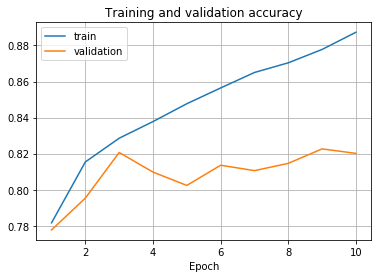

<Figure size 432x288 with 0 Axes>

In [13]:
plot(e, acc, label = 'train')
plot(e, val_acc, label = 'validation')
title('Training and validation accuracy')
xlabel('Epoch')
grid()
legend()

figure()

show()

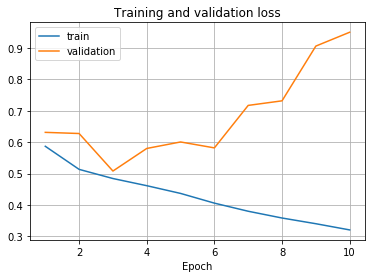

In [14]:
plot(e, loss, label = 'train')
plot(e, val_loss, label = 'validation')
title('Training and validation loss')
xlabel('Epoch')
grid()
legend()

show()

# Evaluating the model with test data
Eventhough the validation results didn't look too promising we actually achieved quite good results when testing with the test data. The overall accuracy is 82%. From the classification report we can see that the model predicts positive and negative reviews quite well. Precision for the negative samples is 0.85 and for the positive samples it's 0.84. Most of the problems come from trying to predict the neutral reviews with only 0.29 precision and 0.15 recall, this has to do with the relatively small amount of neutral reviews in the training data. Usually people only review products they are satisfied or dissapointed with. 

In [20]:
# Find the predicted values for the validation set
model = tf.keras.models.load_model('Case_3_model_1.h10') # Loading the previously saved model
y_pred = argmax(model.predict(x_test), axis = 1)
y_true = argmax(y_test, axis = 1)

## Classification report

In [21]:
# Calculate the classification report
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.85      0.67      0.75     13497
           1       0.29      0.15      0.20      4829
           2       0.84      0.97      0.90     35440

    accuracy                           0.82     53766
   macro avg       0.66      0.60      0.62     53766
weighted avg       0.80      0.82      0.80     53766



## Confusion matrix
From the confusion matrix we can see that the model predicted negative and positive reviews quite well but failed to predict correcty most of the neutral reviews.

In [22]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 8998  1240  3259]
 [  923   734  3172]
 [  643   536 34261]]


## Cohen's kappa
The cohen's kappa score for the predictions is quite good with linear and especially with quadratic weights.<br>
The score rating goes from [-1, 1], where:
- score < 0.4 is poor
- 0.4 < score < 0.75 is fair to good
- score > 0.75 is excellent

In [23]:
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.594
Cohen's kappa (quadratic) = 0.716


## Conclusion
In conclusion the models performance is quite good with the exception of neutral reviews. If we wanted to further improve the model in the future we could try taking into account the usefulCount also so the reviews which have been deemed good by many other users are given more weight than the reviews that are not found very helpful. 